In [1]:
# General imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys, gc, time, warnings, pickle, psutil, random

from math import ceil

from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

warnings.filterwarnings('ignore')

DIR = "C:/Users/Yipeng/Contest/BDCI2023/code/"
DIR_DATA_RAW = DIR + "data/"
DIR_DATA_PRE = DIR + "data/preprocessed/"
DIR_MODEL = DIR + "model/"
DIR_MODEL_LGB = DIR_MODEL + "lgb/"

In [2]:
import lightgbm as lgb

data_merged = pd.read_pickle(DIR_DATA_PRE + "data_merged.pkl")

In [3]:
lst = []
for day in [1,3,5,7,14,21,30,60,90]:
    lst.append(f"sales_{day}_mean")
    lst.append(f"sales_{day}_std")
    lst.append(f"sales_{day}_mean_change")
data_merged.drop(lst, axis=1, inplace=True)

In [4]:
def test_by_store_id(store_id: int):
    # 加载模型
    model = lgb.Booster(model_file=DIR_MODEL_LGB + f'store_{store_id}_final.txt')
    # 加载要预测的数据
    data_store = data_merged[data_merged['store_id'] == store_id]
    data_pred = data_store[data_store['date'] >= '2023-08-31']
    # 预测
    data_pred['quantity'] = model.predict(data_pred.drop(["quantity", "date"], axis=1))
    # 只保留需要的列
    data_pred = data_pred[['store_id', 'sku_id', 'date', 'quantity']]
    return data_pred


In [13]:
pred_all_list = []
for store_id in range(1, 13):
    print(f"predicting store_id={store_id} ...")
    pred_all_list.append(test_by_store_id(store_id))
pred_all = pd.concat(pred_all_list)

predicting store_id=1 ...
predicting store_id=2 ...
predicting store_id=3 ...
predicting store_id=4 ...
predicting store_id=5 ...
predicting store_id=6 ...
predicting store_id=7 ...
predicting store_id=8 ...
predicting store_id=9 ...
predicting store_id=10 ...
predicting store_id=11 ...
predicting store_id=12 ...


In [14]:
pred_all

,store_id,sku_id,date,quantity
1460,1,1,2023-08-31,1.255087
1462,1,1,2023-09-01,1.810575
1464,1,1,2023-09-02,2.411828
1466,1,1,2023-09-03,2.432882
1468,1,1,2023-09-04,1.335559
...,...,...,...,...
10262841,12,1000,2023-09-10,0.403120
10262843,12,1000,2023-09-11,0.320891
10262845,12,1000,2023-09-12,0.340555
10262847,12,1000,2023-09-13,0.419042


In [15]:
pred_all['quantity'] = pred_all['quantity'].apply(lambda x: 0 if x < 0.5 else ceil(x))

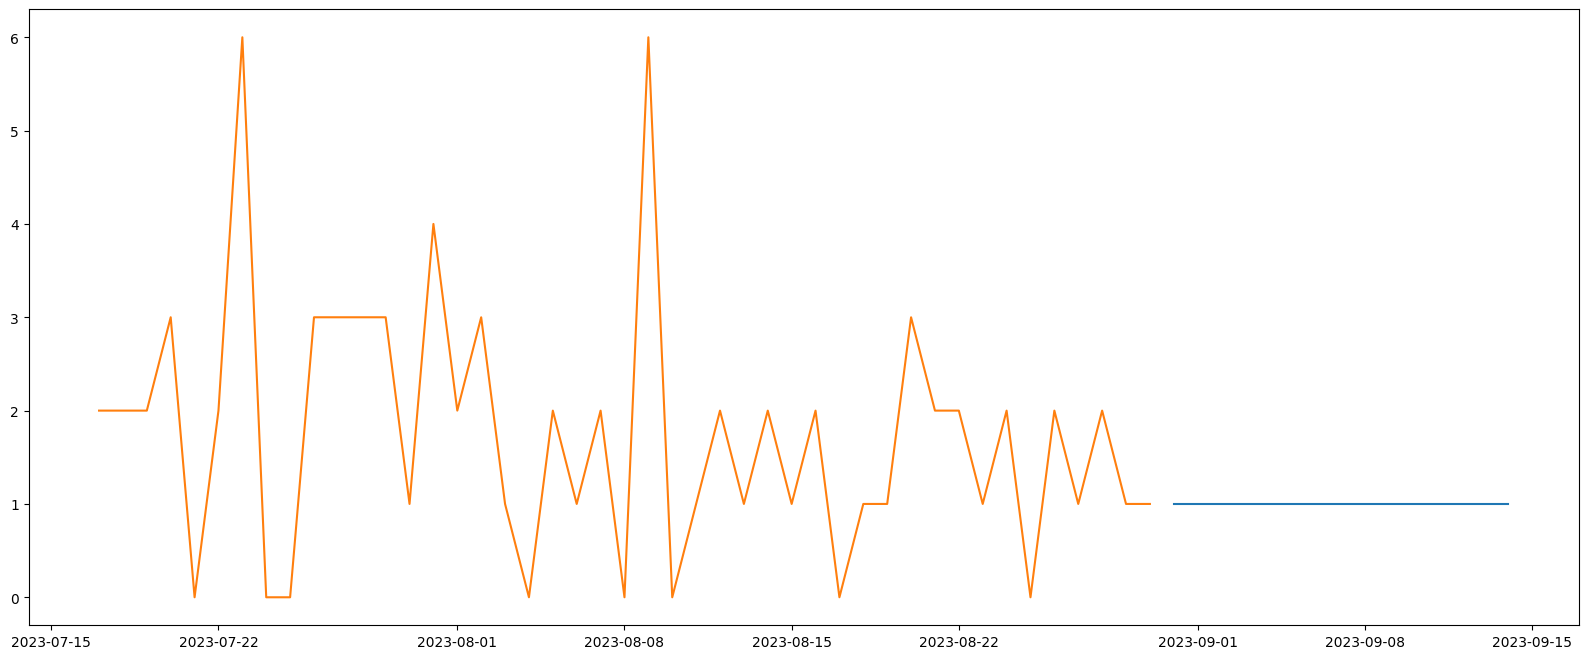

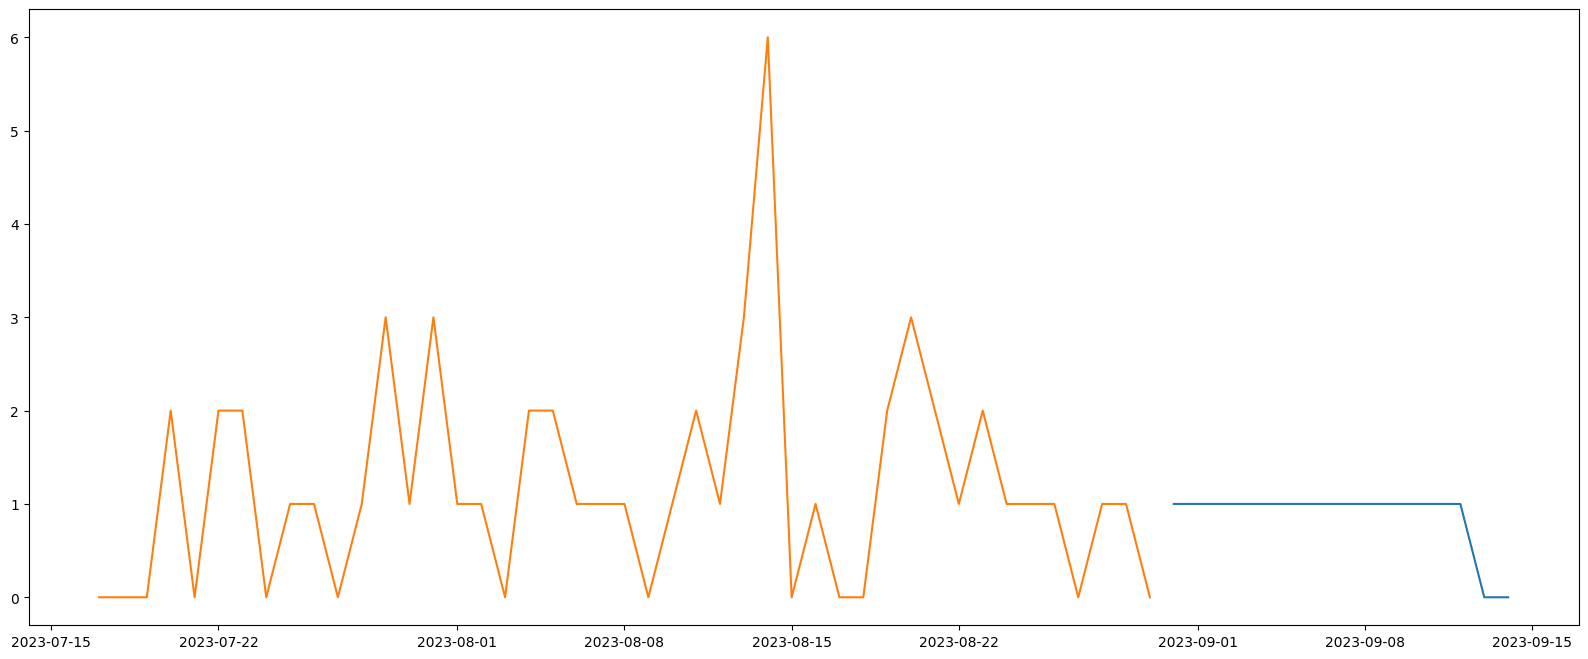

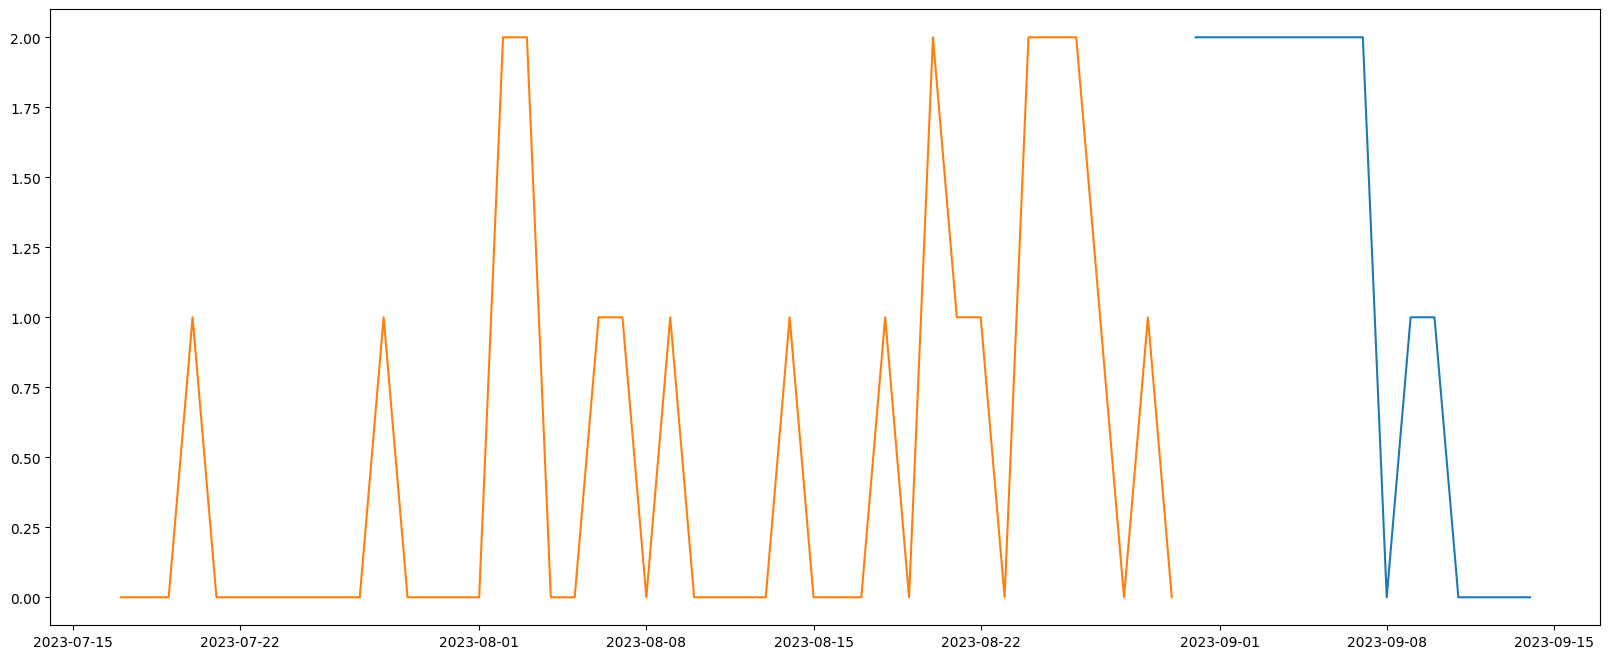

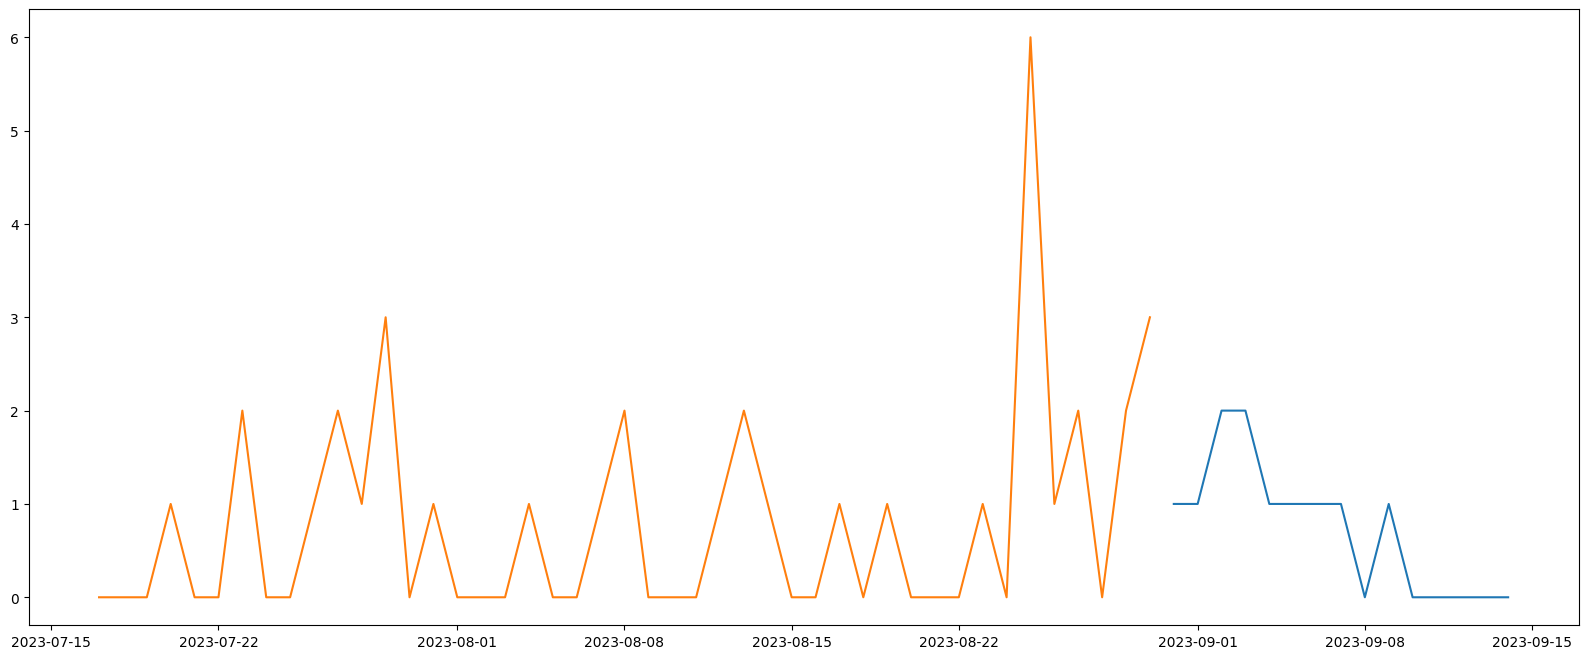

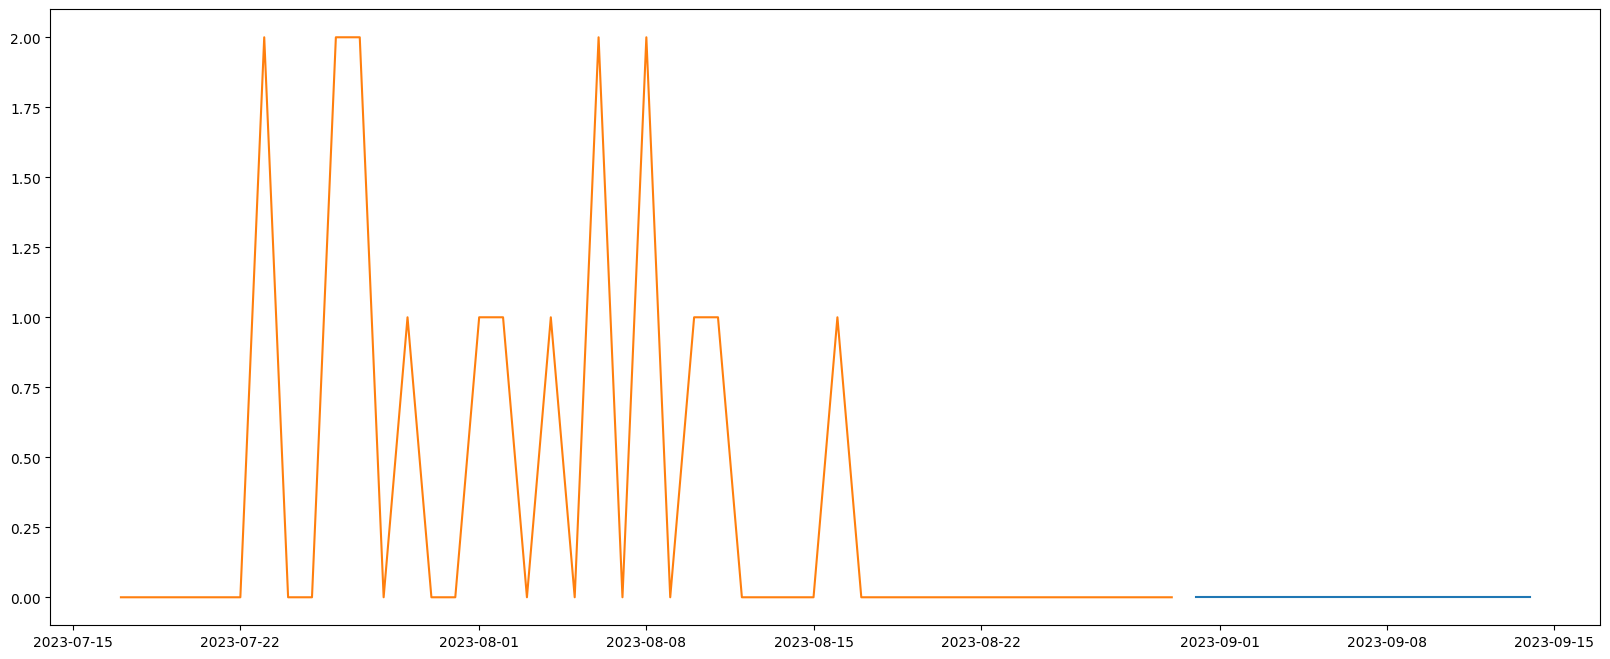

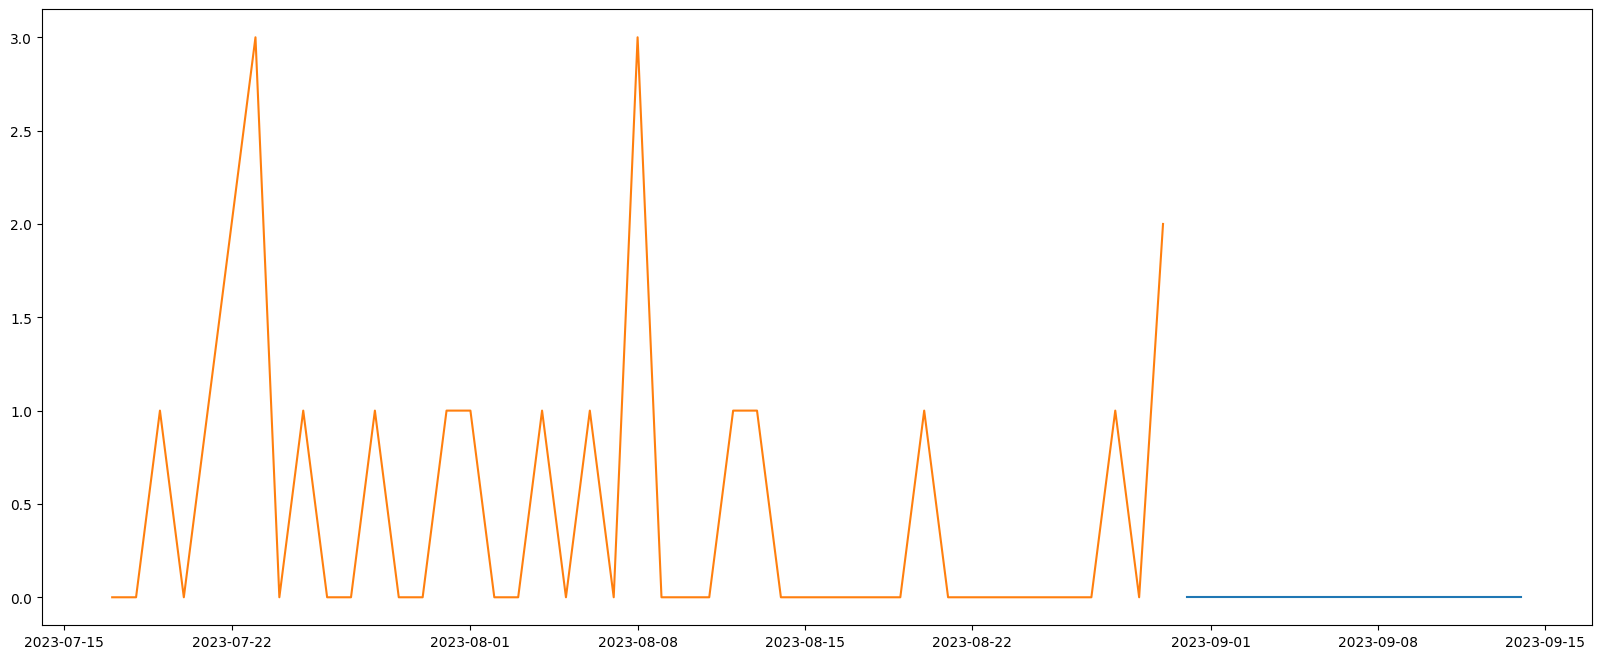

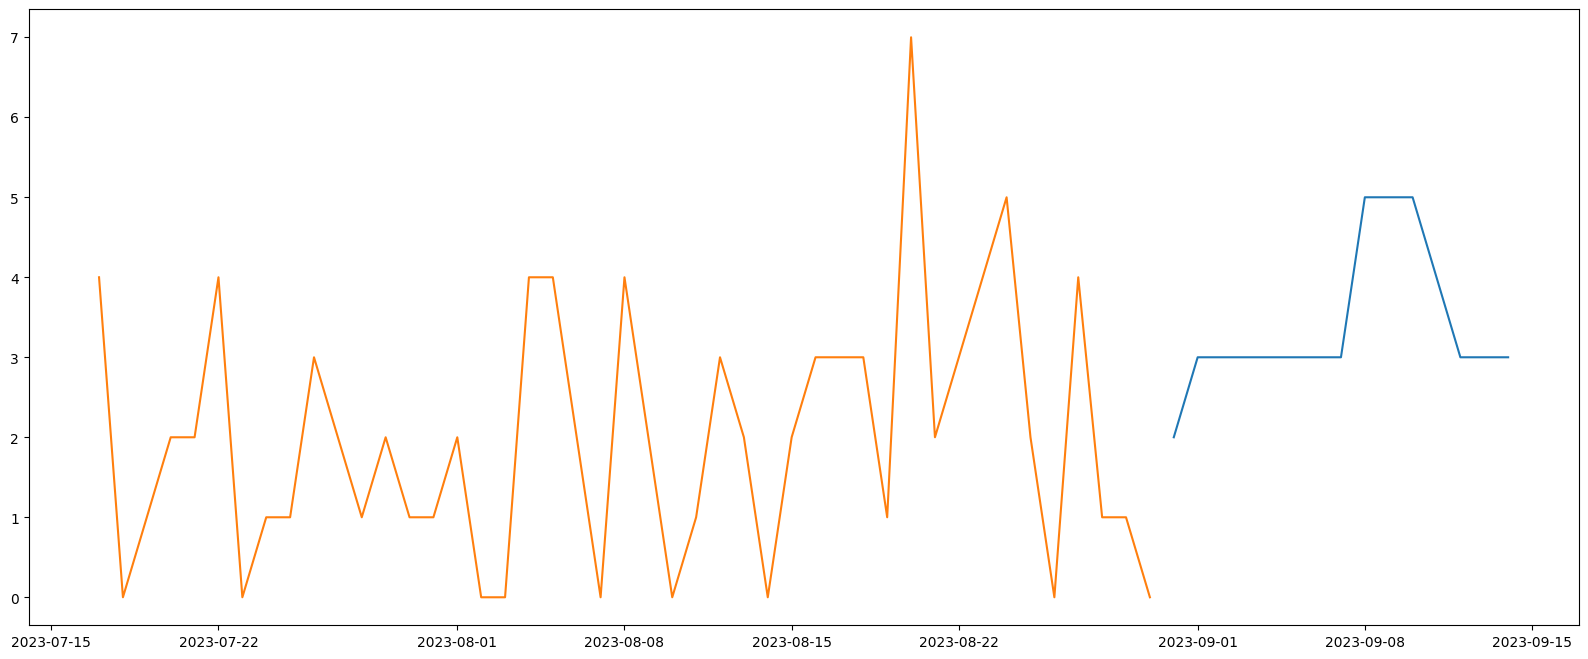

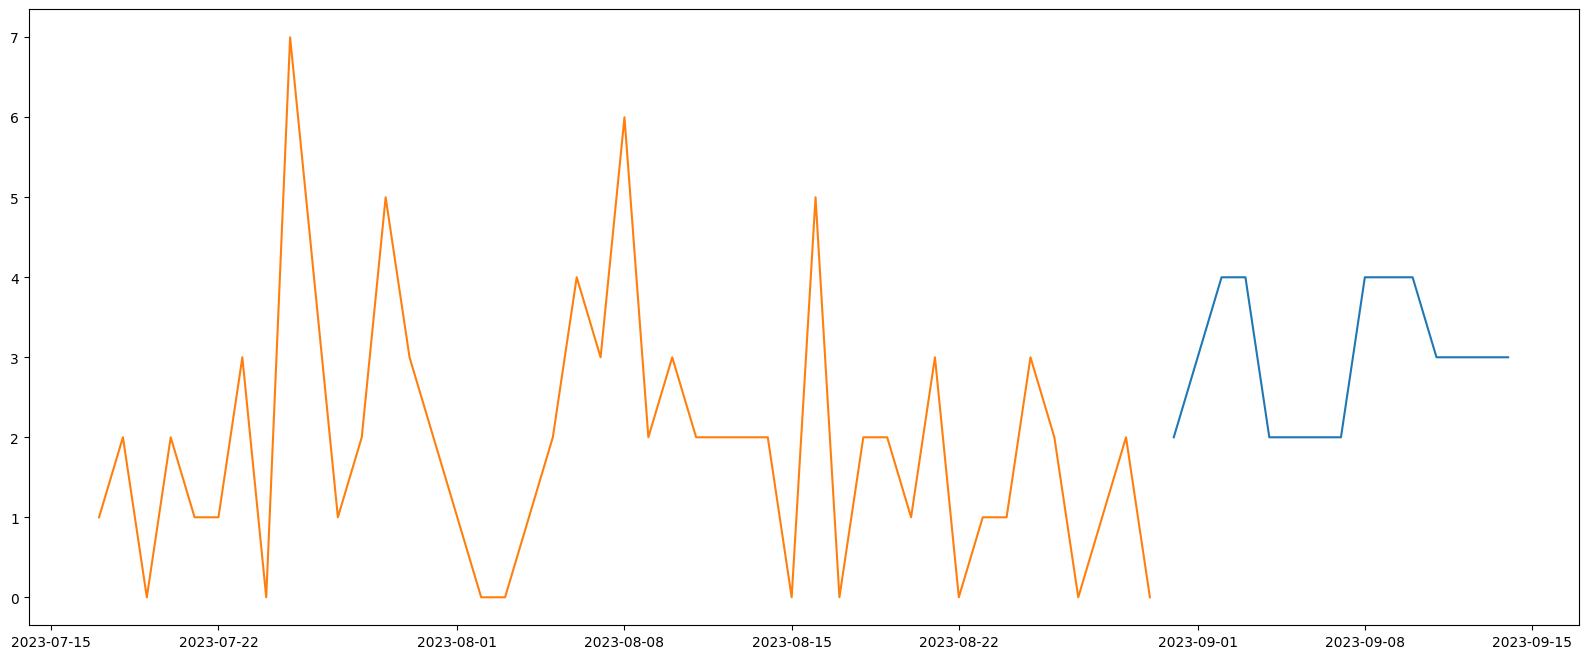

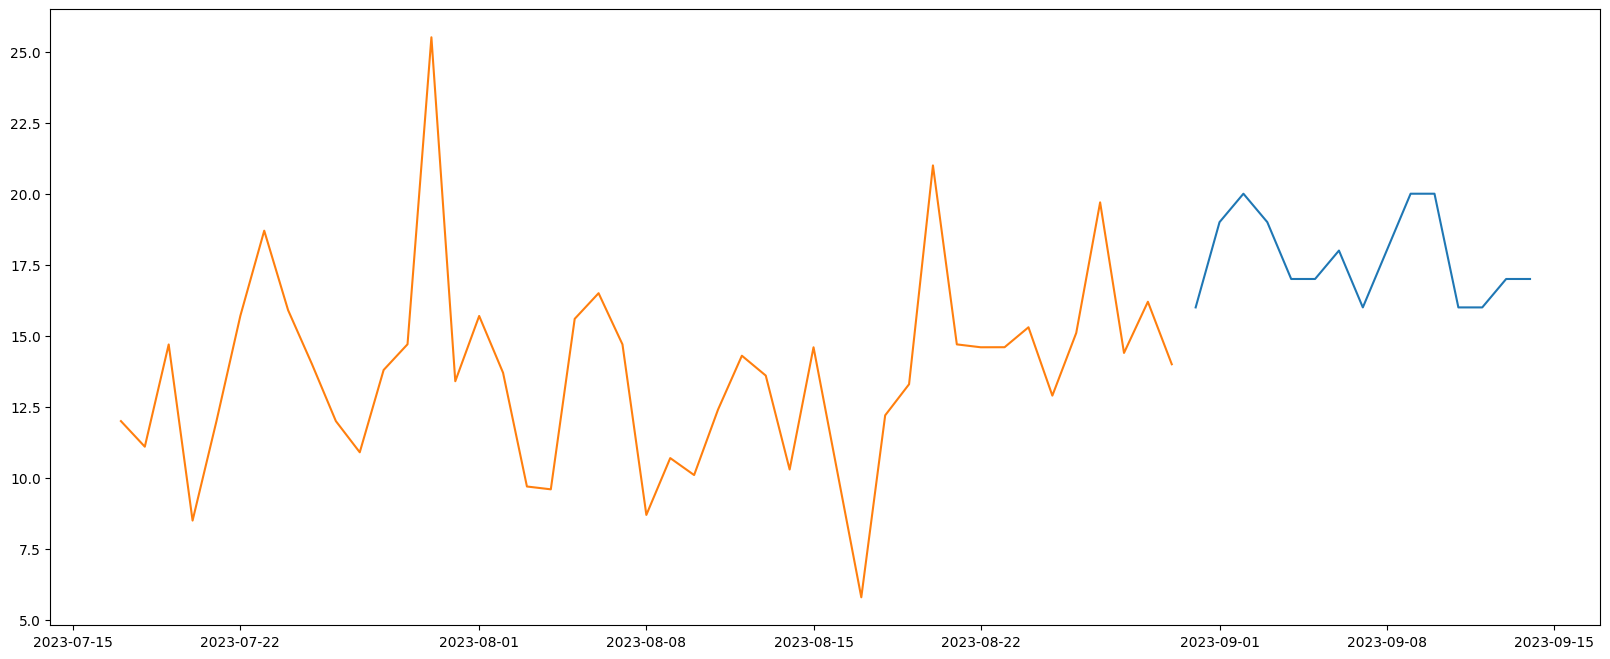

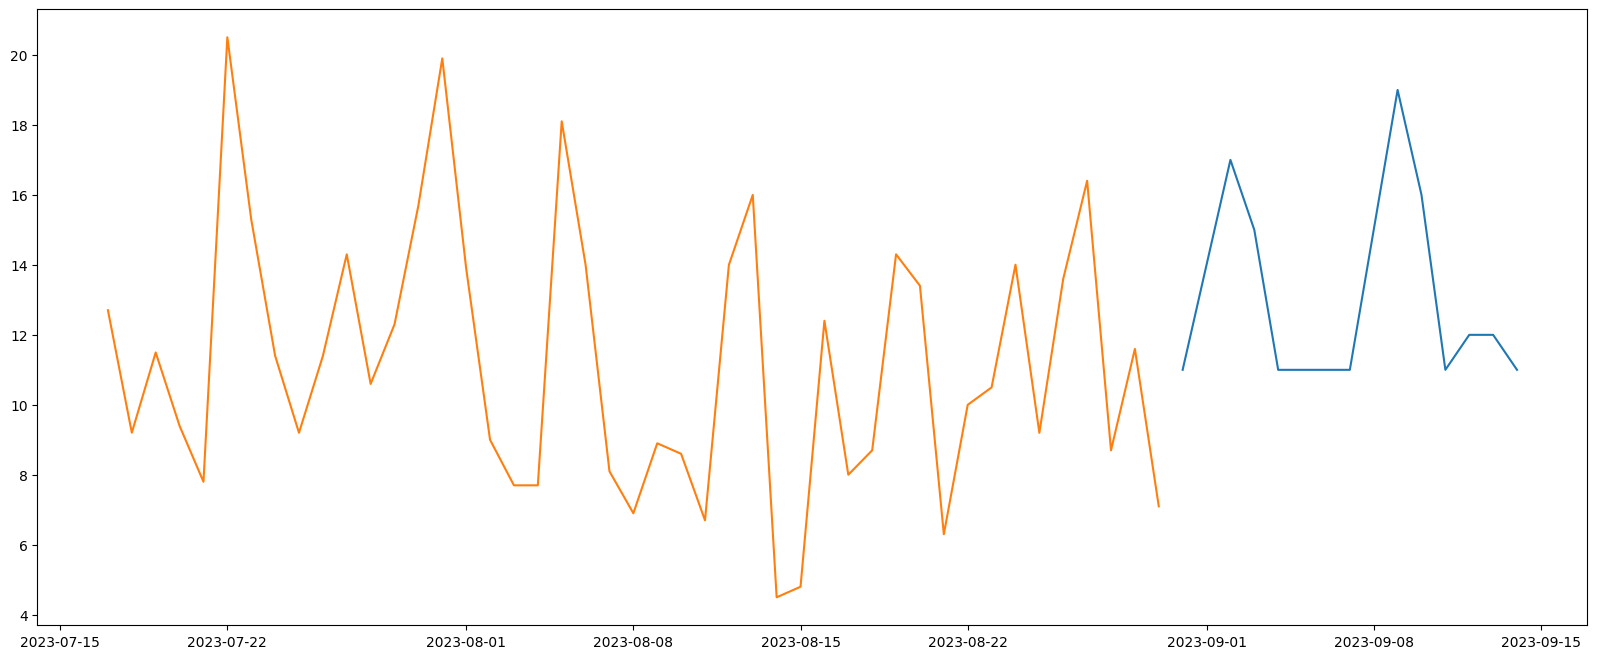

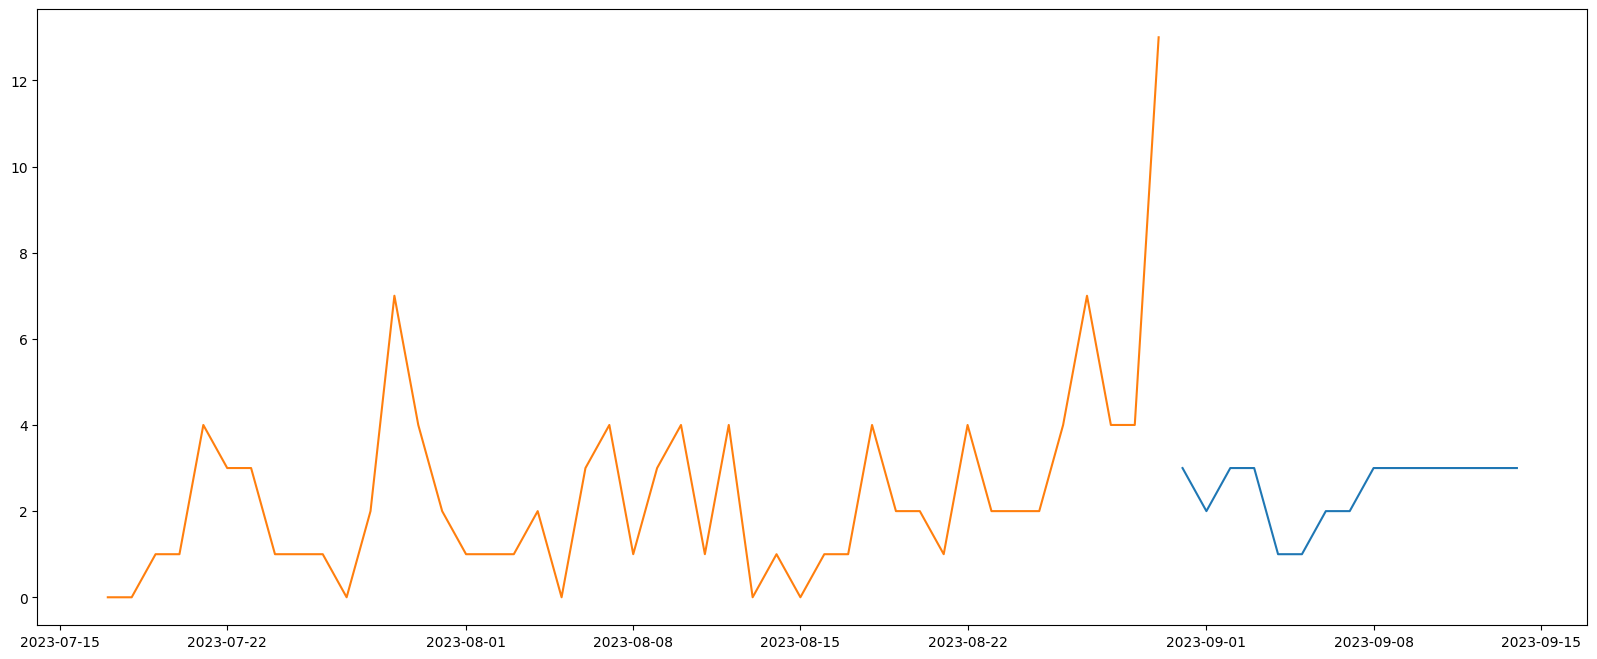

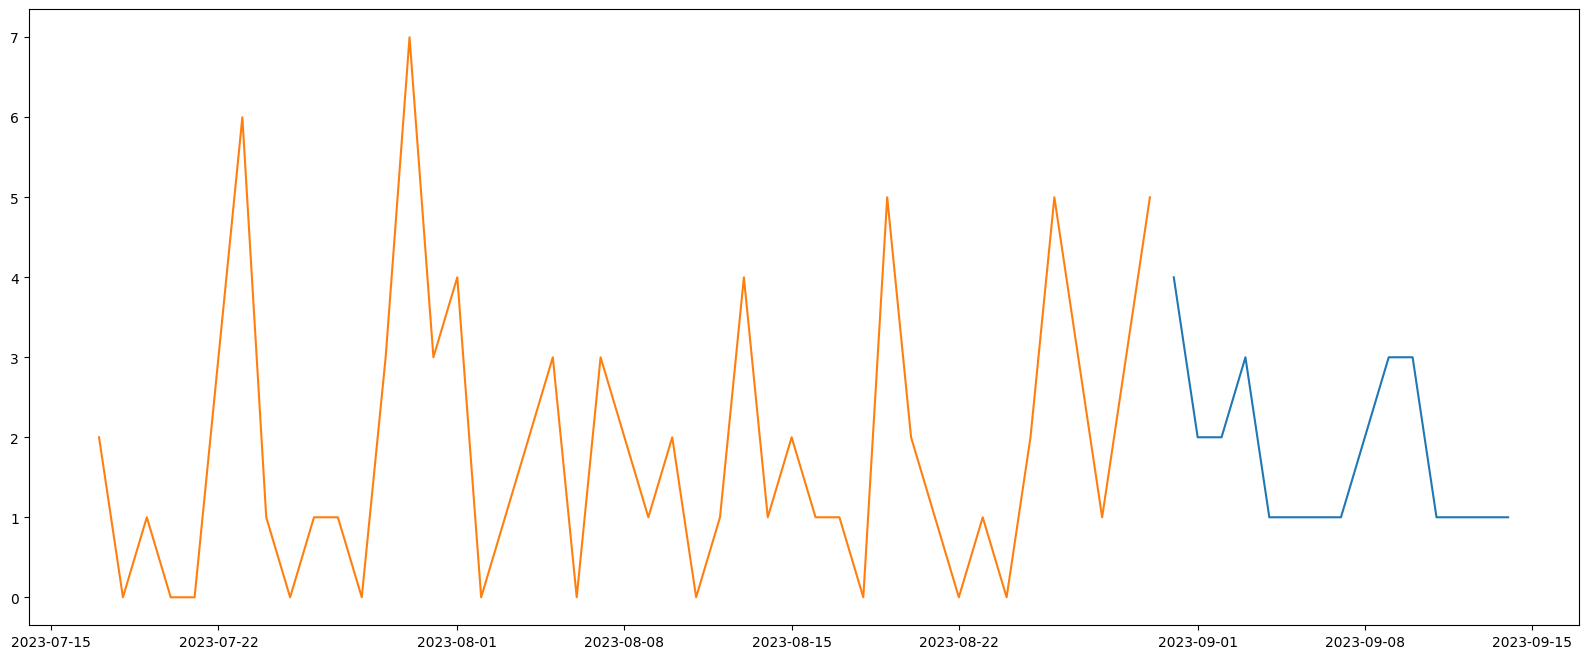

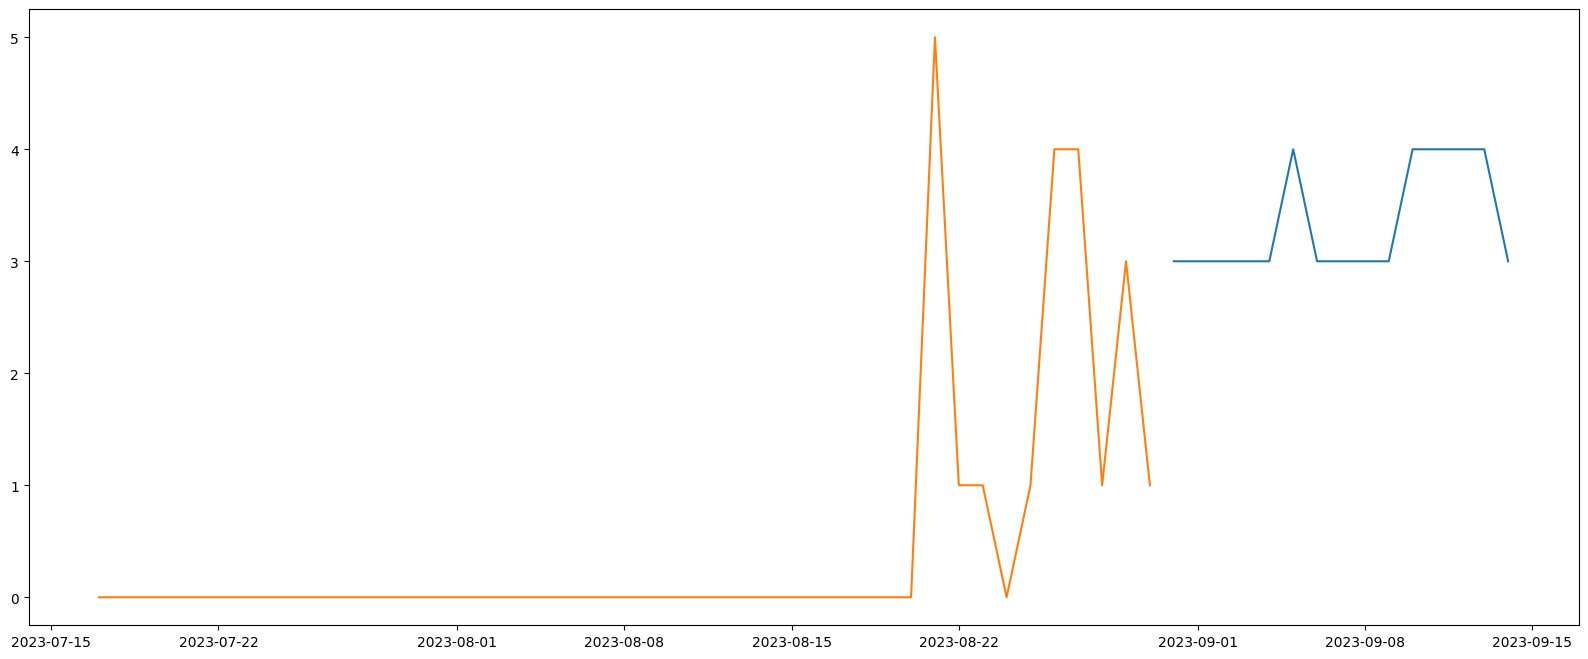

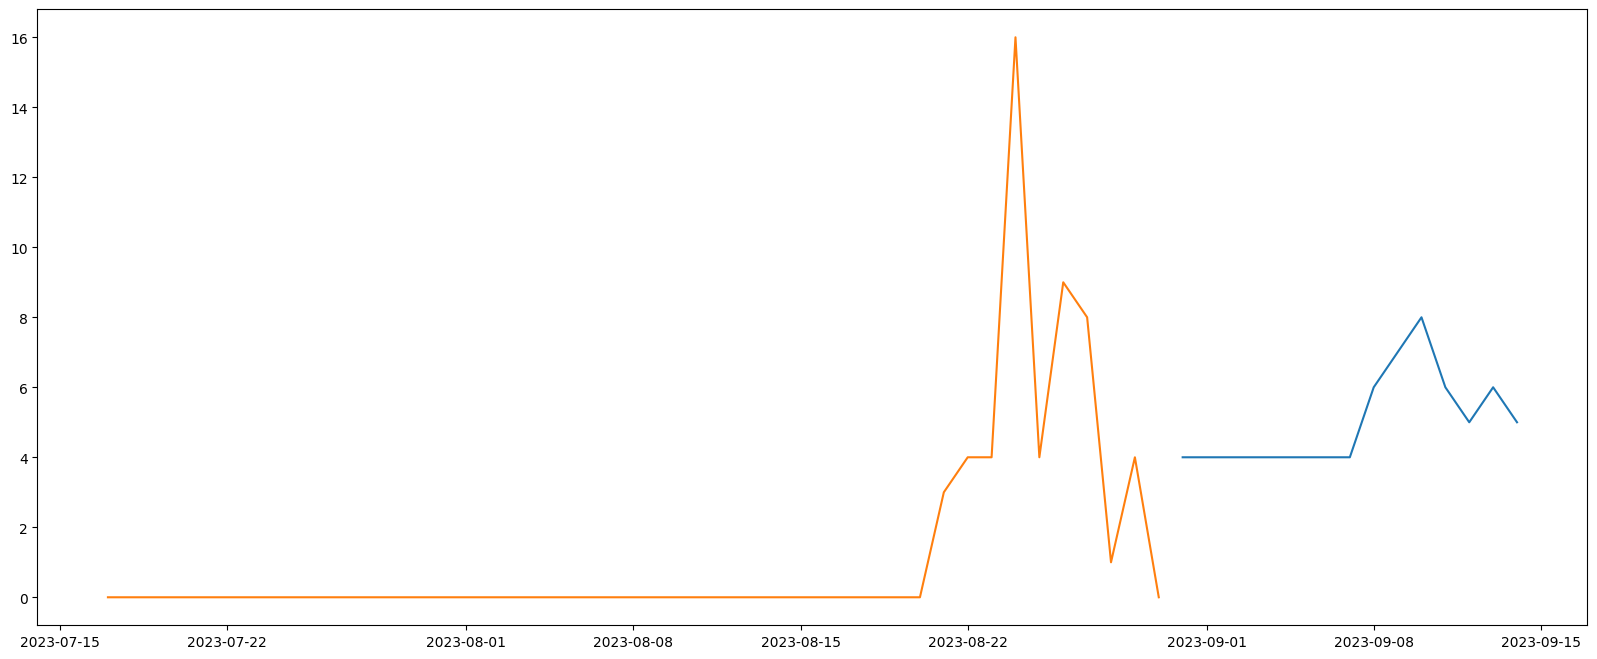

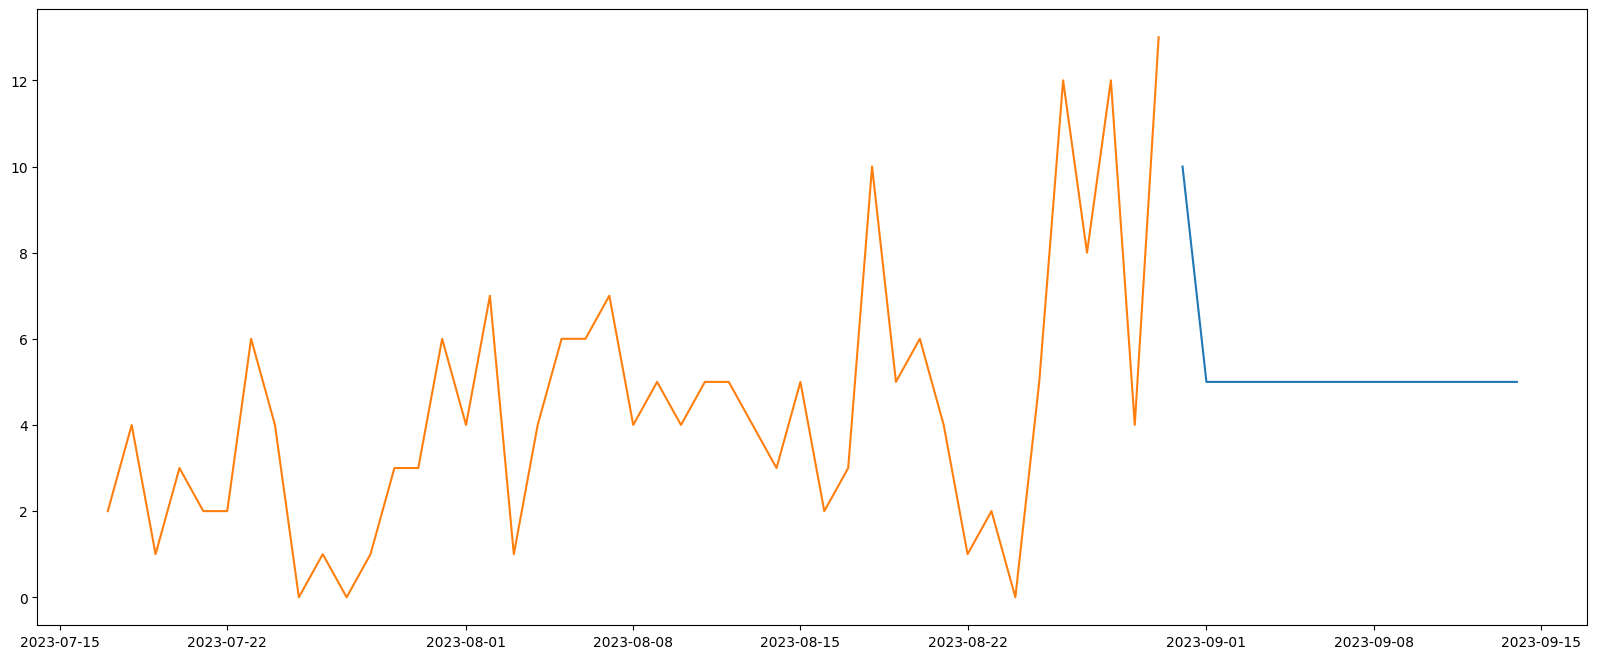

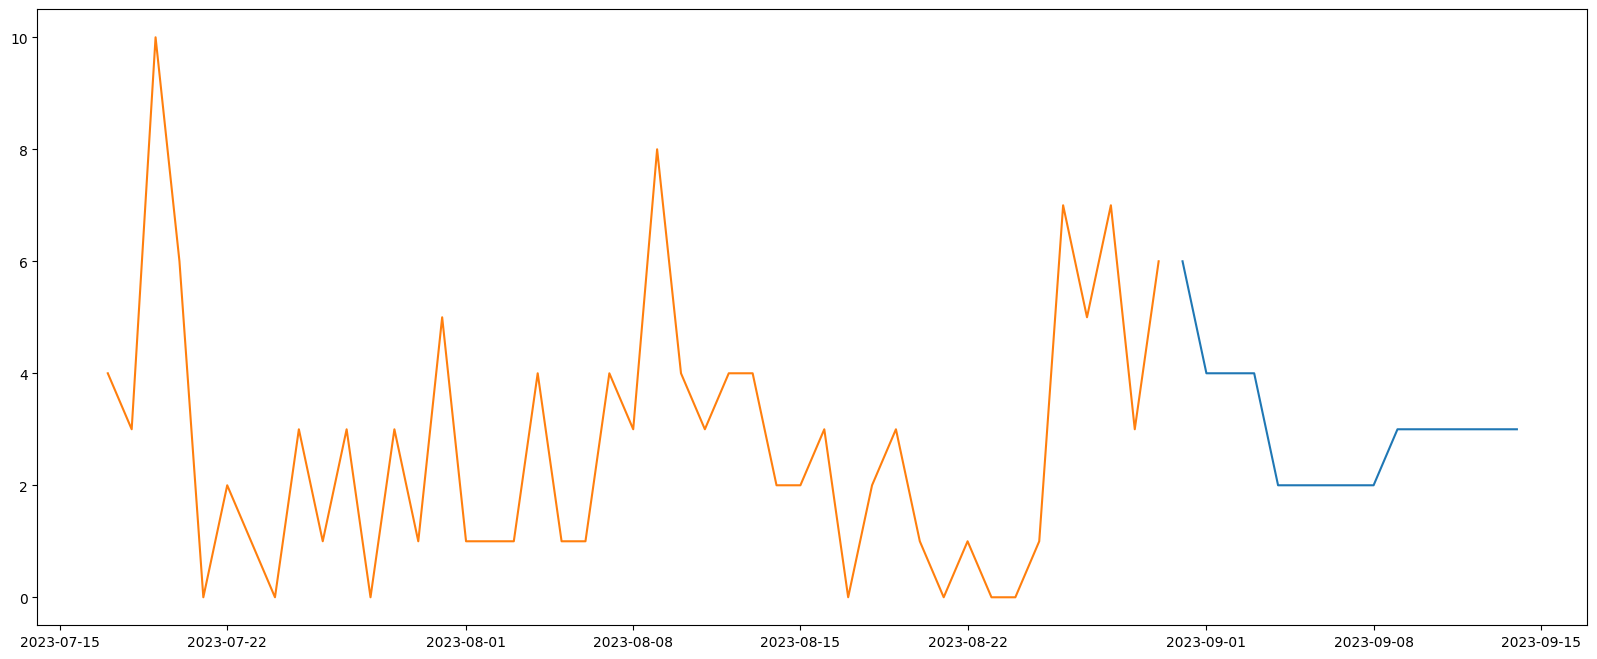

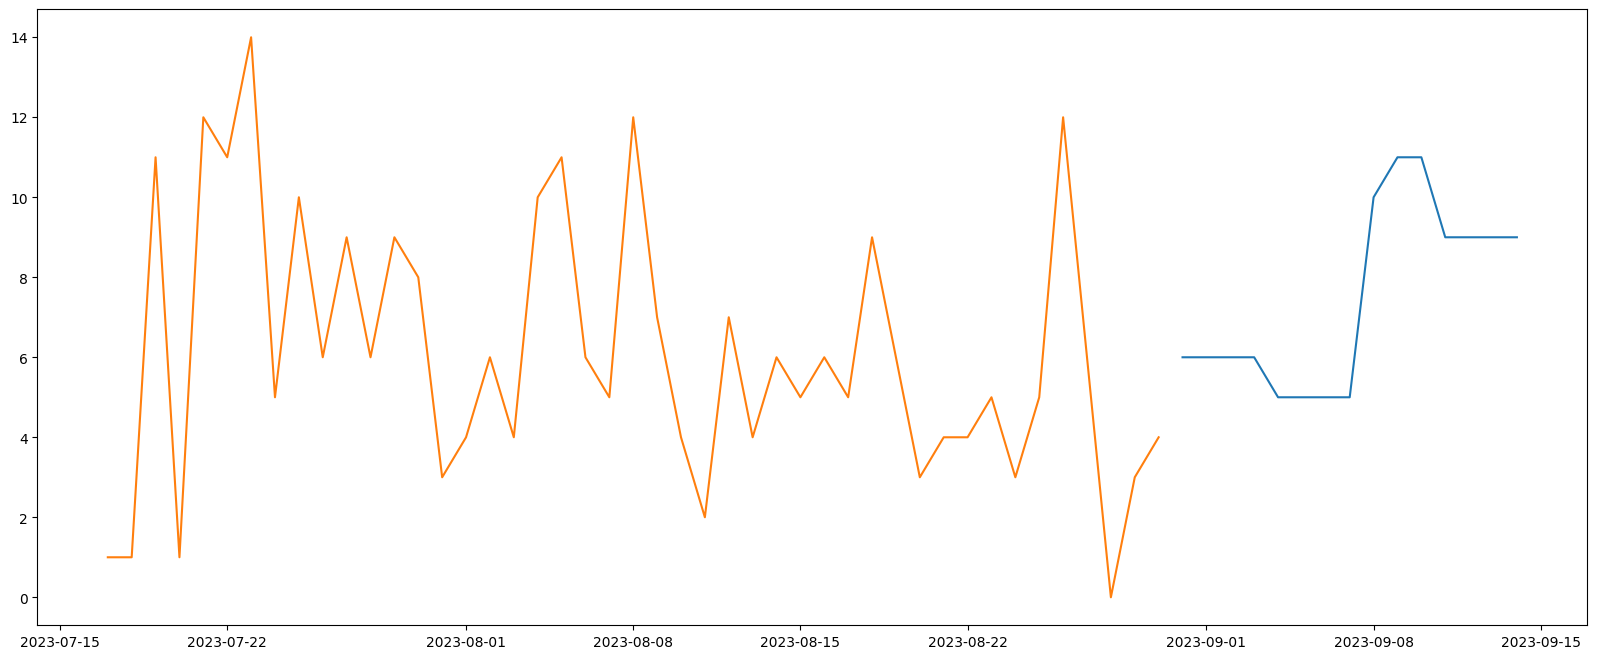

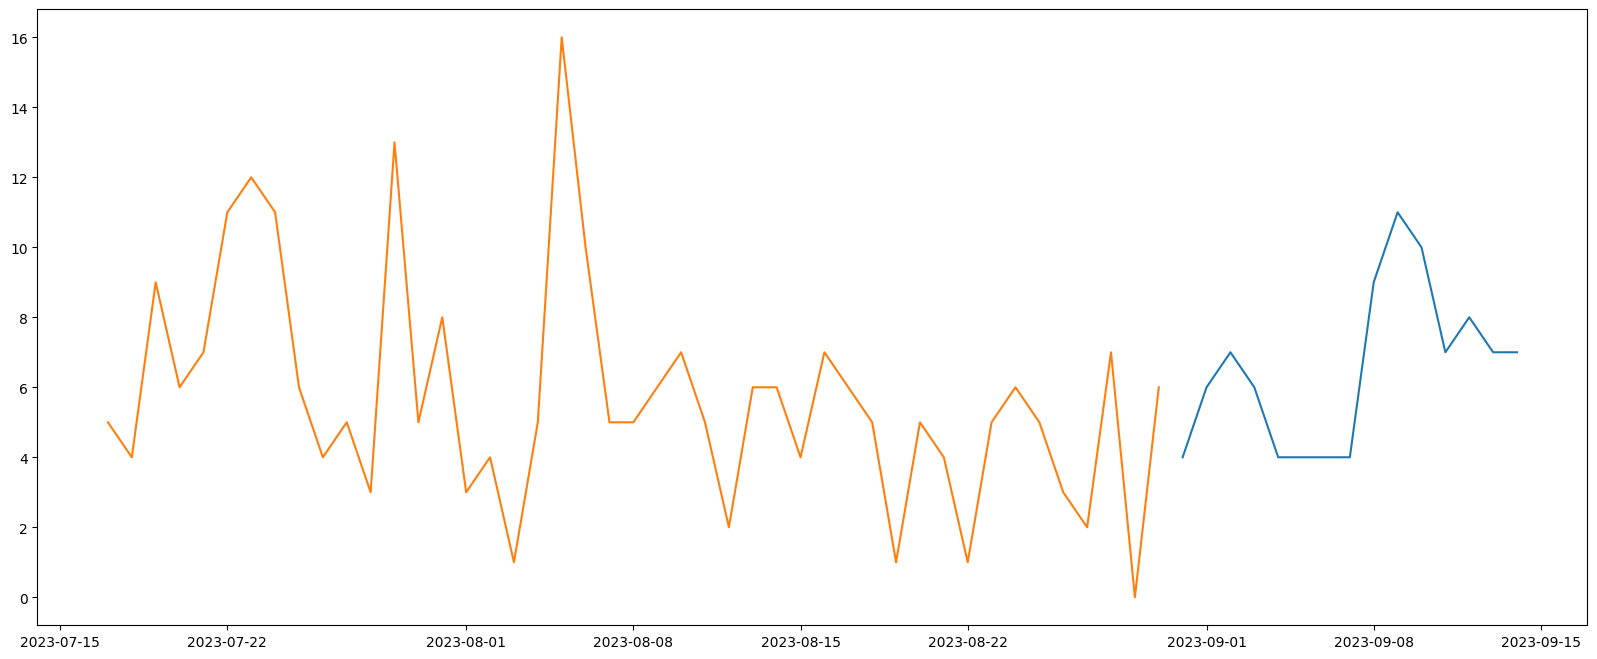

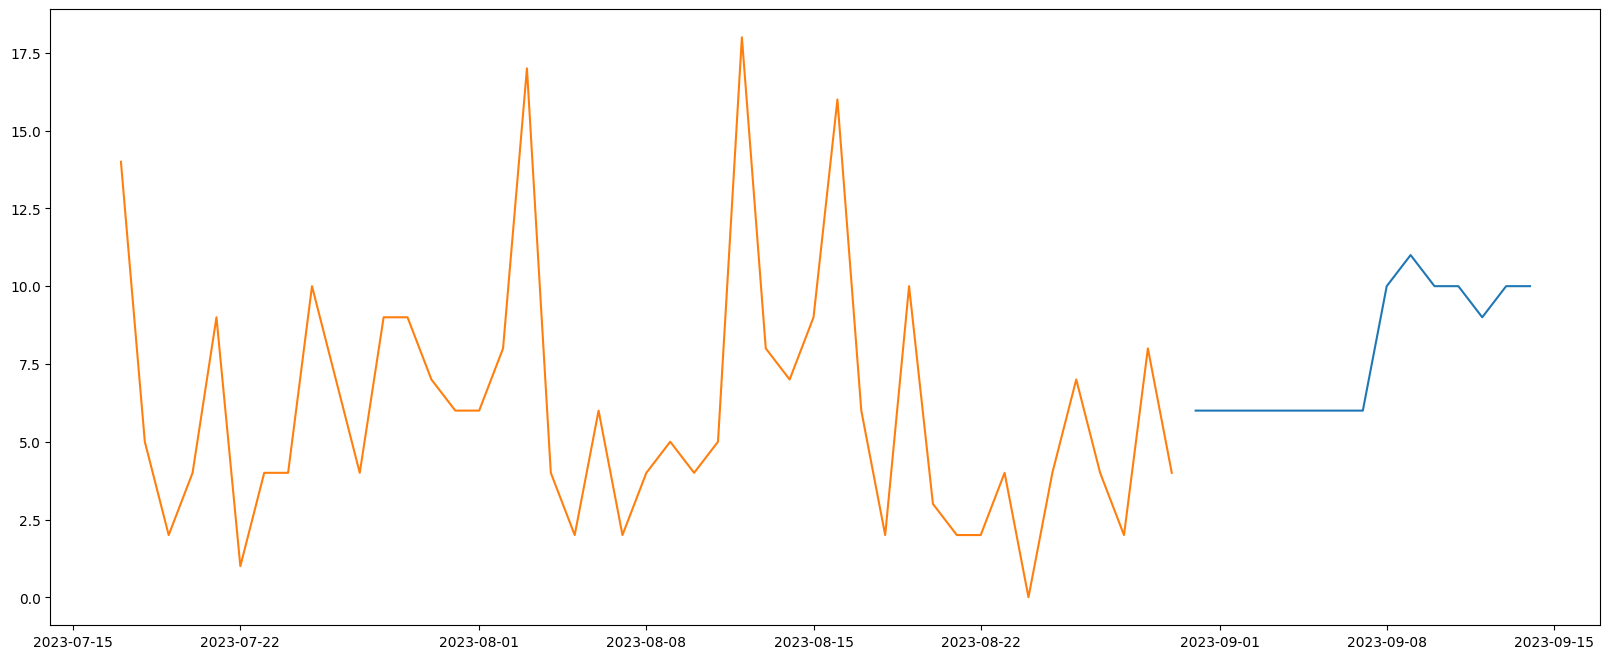

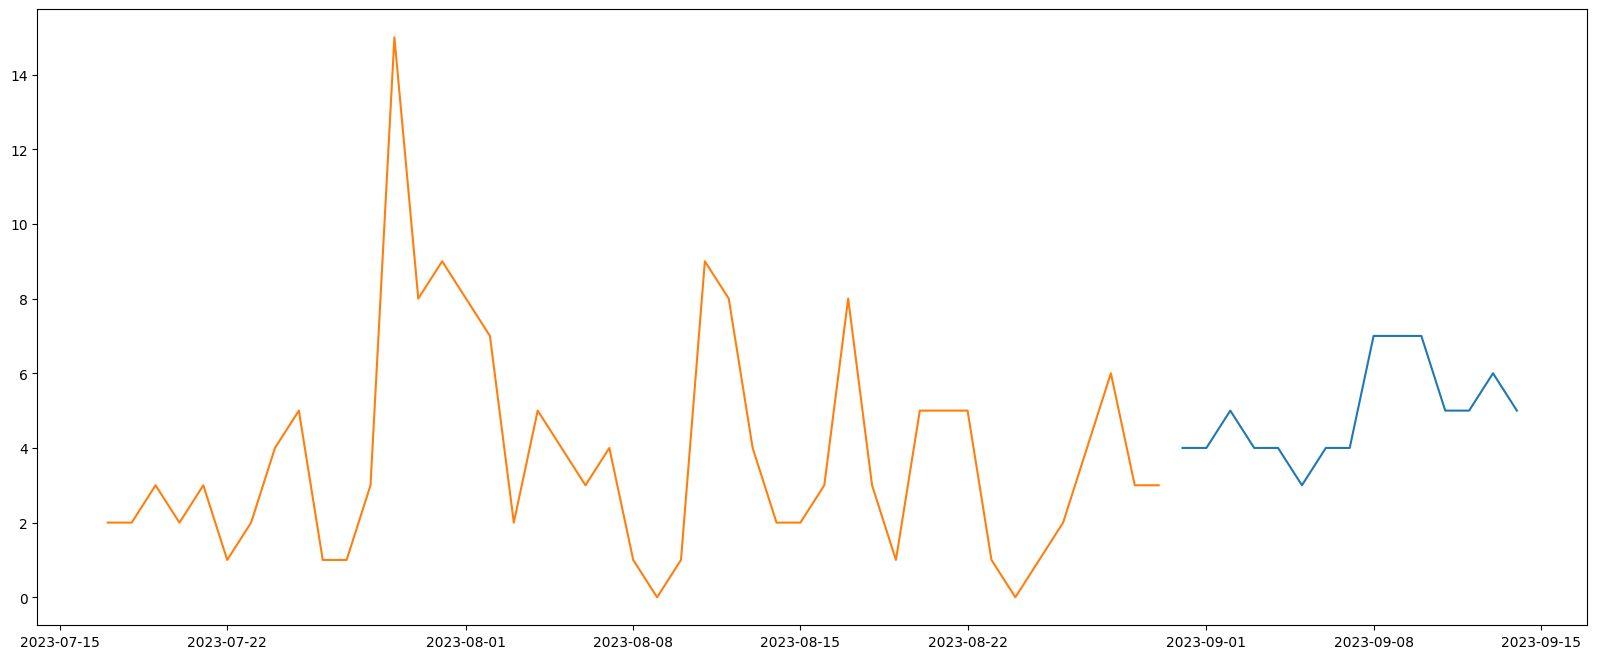

In [24]:
for sku_id in range(40, 50):
    for store_id in [10, 11]:
        temp = pred_all[(pred_all['sku_id'] == sku_id) & (pred_all['store_id'] == store_id)].groupby(['sku_id', 'store_id', 'date'])['quantity'].sum().reset_index()
        aaa  = data_merged[(data_merged['sku_id'] == sku_id) & (data_merged['store_id'] == store_id)].groupby(['sku_id', 'store_id', 'date'])['quantity'].sum().reset_index()
        # print(temp)
        plt.figure(figsize=(20, 8))
        plt.plot(temp['date'], temp['quantity'])
        plt.plot(aaa['date'][-60:-15], aaa['quantity'][-60:-15])
        plt.show()

In [25]:
# store_id从1-12，sku_id从1-1000，order_time从2023-08-18到2023-08-31
store_ids = list(range(1, 13))
sku_ids = list(range(1, 1001))
dates = pd.date_range('2023-09-01', '2023-09-14').date

# 生成store_id, sku_id, order_time的笛卡尔积
cartesian = pd.MultiIndex.from_product([store_ids, sku_ids, dates], names=['store_id', 'sku_id', 'date'])
data_now_stocks = pd.DataFrame(cartesian.to_frame(), columns=['store_id', 'sku_id', 'date']).reset_index(drop=True)
data_now_stocks["date"] = pd.to_datetime(data_now_stocks["date"]).dt.date
data_now_stocks

,store_id,sku_id,date
0,1,1,2023-09-01
1,1,1,2023-09-02
2,1,1,2023-09-03
3,1,1,2023-09-04
4,1,1,2023-09-05
...,...,...,...
167995,12,1000,2023-09-10
167996,12,1000,2023-09-11
167997,12,1000,2023-09-12
167998,12,1000,2023-09-13


In [26]:
pred_all['date'] = pd.to_datetime(pred_all['date']).dt.date
ans = pred_all.groupby(['store_id', 'sku_id', 'date'])['quantity'].sum().reset_index()
data_now_stocks = pd.merge(data_now_stocks, ans, how='left')
data_now_stocks.fillna(0, inplace=True)
data_now_stocks

,store_id,sku_id,date,quantity
0,1,1,2023-09-01,3.0
1,1,1,2023-09-02,4.0
2,1,1,2023-09-03,4.0
3,1,1,2023-09-04,3.0
4,1,1,2023-09-05,2.0
...,...,...,...,...
167995,12,1000,2023-09-10,1.0
167996,12,1000,2023-09-11,1.0
167997,12,1000,2023-09-12,1.0
167998,12,1000,2023-09-13,1.0


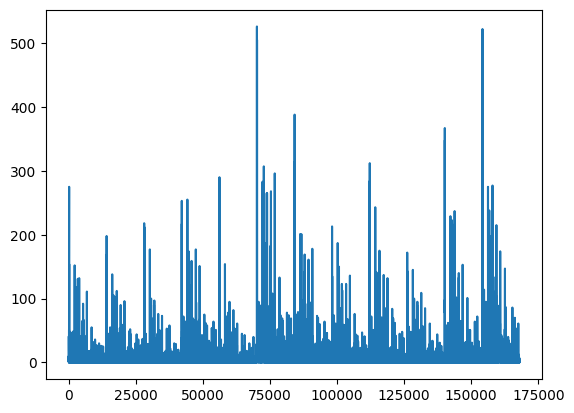

In [27]:
plt.plot(data_now_stocks['quantity'])
plt.show()

In [28]:
temp = pd.read_csv("./data/test/test_results.csv")

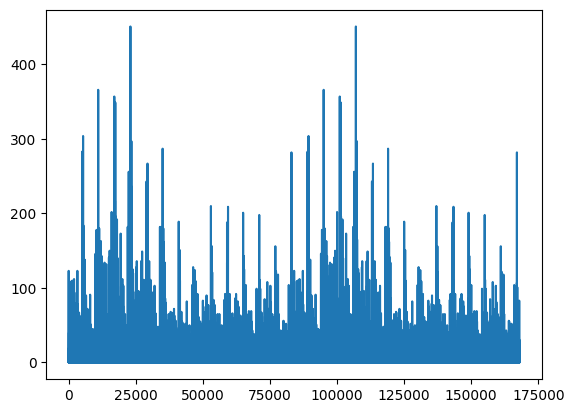

In [29]:
plt.plot(temp['x_k'])
plt.show()

In [30]:
data_now_stocks.rename(columns={'quantity': 'x_k'}, inplace=True)
data_now_stocks['x_m'] = 0
data_now_stocks

,store_id,sku_id,date,x_k,x_m
0,1,1,2023-09-01,3.0,0
1,1,1,2023-09-02,4.0,0
2,1,1,2023-09-03,4.0,0
3,1,1,2023-09-04,3.0,0
4,1,1,2023-09-05,2.0,0
...,...,...,...,...,...
167995,12,1000,2023-09-10,1.0,0
167996,12,1000,2023-09-11,1.0,0
167997,12,1000,2023-09-12,1.0,0
167998,12,1000,2023-09-13,1.0,0


In [31]:
data_now_stocks.to_csv("./submit/csv/test_results_11_12_store.csv", index=False)